In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter

In [ ]:
# File path for the ratings CSV
file_path = "./content/ml-32m/ratings.csv"

ratings_df = pd.read_csv(file_path)

ratings_df.head()

NameError: name 'pd' is not defined

In [ ]:
# Number of unique users
num_users = len(ratings_df["userId"].unique())
print(f"Number of unique users: {num_users}")

# Number of unique movies
num_movies = len(ratings_df["movieId"].unique())
print(f"Number of unique movies: {num_movies}")

# Maximum and minimum ratings
max_rating = ratings_df["rating"].max()
min_rating = ratings_df["rating"].min()
print(f"Maximum rating: {max_rating}")
print(f"Minimum rating: {min_rating}")

# Additional dataset insights
# Number of ratings
num_ratings = len(ratings_df)
print(f"Total number of ratings: {num_ratings}")

# Distribution of ratings
print("Ratings distribution:")
print(ratings_df["rating"].value_counts().sort_index())


Number of unique users: 200948
Number of unique movies: 84432
Maximum rating: 5.0
Minimum rating: 0.5
Total number of ratings: 32000204
Ratings distribution:
0.5     525132
1.0     946675
1.5     531063
2.0    2028622
2.5    1685386
3.0    6054990
3.5    4290105
4.0    8367654
4.5    2974000
5.0    4596577
Name: rating, dtype: int64


In [ ]:
# Load the ratings dataset manually
file_path = "./ml-32m/ratings.csv"
ratings_dataset = []
with open(file_path, "r") as file:
    next(file)  # Skip the header line
    for line in file:
        user_id, movie_id, rating, _ = line.strip().split(",")
        ratings_dataset.append((int(user_id), int(movie_id), float(rating)))


FileNotFoundError: [Errno 2] No such file or directory: './ml-32m/ratings.csv'

In [ ]:
# Create mappings for user IDs and movie IDs
USER_TO_IDX = {user_id: user_idx for user_idx, user_id in enumerate(ratings_df["userId"].unique())}
MOVIE_TO_IDX = {movie_id: movie_idx for movie_idx, movie_id in enumerate(ratings_df["movieId"].unique())}

# Reverse mappings for index-to-ID conversions
idx_to_user = list(USER_TO_IDX.keys())  # List of user IDs by index
idx_to_movie = list(MOVIE_TO_IDX.keys())  # List of movie IDs by index


NameError: name 'ratings_df' is not defined

In [ ]:
# Calculate the total number of unique users and movies
NUM_USERS = len(idx_to_user)
NUM_MOVIES = len(idx_to_movie)

# Output the number of users and movies
NUM_USERS, NUM_MOVIES

NameError: name 'idx_to_user' is not defined

In [ ]:
# Initialize data structures to store user and movie data
USERS_DATA = [[] for _ in range(NUM_USERS)]  # Each user will have a list of (movieIdx, rating) tuples
MOVIES_DATA = [[] for _ in range(NUM_MOVIES)]  # Each movie will have a list of (userIdx, rating) tuples

# Populate USERS_DATA and MOVIES_DATA
for user_id, movie_id, rating in ratings_dataset:
    user_idx = USER_TO_IDX[user_id]
    movie_idx = MOVIE_TO_IDX[movie_id]
    USERS_DATA[user_idx].append((movie_idx, rating))
    MOVIES_DATA[movie_idx].append((user_idx, rating))

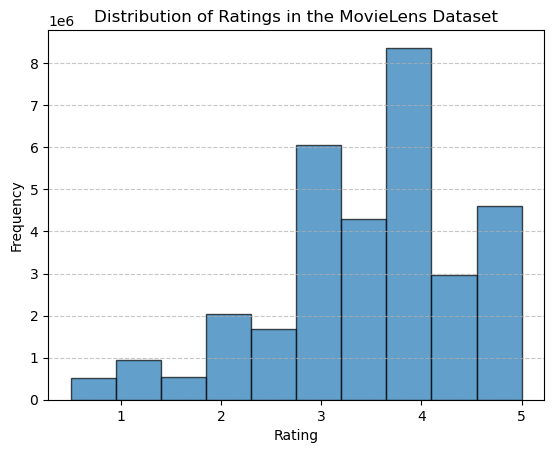

In [ ]:
# Plot the distribution of ratings
plt.hist(
    ratings_df['rating'],
    bins=10,
    edgecolor='black',
    alpha=0.7
)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings in the MovieLens Dataset")
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.show()


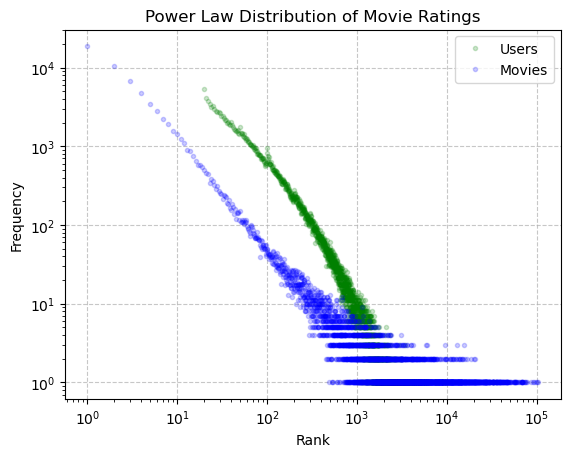

In [ ]:
# Calculate the number of ratings per movie and per user
ratings_per_movie = [len(movie_data) for movie_data in MOVIES_DATA]
ratings_per_user = [len(user_data) for user_data in USERS_DATA]

# Count the frequency of rating counts
user_rating_frequency = Counter(ratings_per_user)
movie_rating_frequency = Counter(ratings_per_movie)

# Plot the power law distribution for users and movies
plt.loglog(
    user_rating_frequency.keys(),
    user_rating_frequency.values(),
    ".",
    color="g",
    alpha=0.2,
    label="Users"
)
plt.loglog(
    movie_rating_frequency.keys(),
    movie_rating_frequency.values(),
    ".",
    color="b",
    alpha=0.2,
    label="Movies"
)

# Add labels, title, grid, and legend
plt.ylabel("Frequency")
plt.xlabel("Rank")
plt.title("Power Law Distribution of Movie Ratings")
plt.grid(linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [ ]:
def init_empty_data(size):
    """
    Initializes a list of empty lists with a specified size.

    Parameters:
    size (int): The number of empty lists to create.

    Returns:
    list: A list of empty lists.
    """
    return [[] for _ in range(size)]

In [ ]:
def create_user_ds(user_data):
    """
    Creates user-specific datasets for watched movies and given ratings.

    Parameters:
    user_data (list): A list of user interactions with movies.

    Returns:
    tuple: Two lists - one with movie IDs watched by each user and one with their corresponding ratings.
    """
    users_watched_movies = [[] for _ in range(len(user_data))]
    users_given_ratings = [[] for _ in range(len(user_data))]

    for user_idx, user_movies in enumerate(user_data):
        users_watched_movies[user_idx] = [movie_id for movie_id, _ in user_movies]
        users_given_ratings[user_idx] = [rating for _, rating in user_movies]

    return users_watched_movies, users_given_ratings

def create_movie_ds(movie_data):
    """
    Creates movie-specific datasets for users who watched and their ratings.

    Parameters:
    movie_data (list): A list of movie interactions with users.

    Returns:
    tuple: Two lists - one with user IDs who watched each movie and one with their corresponding ratings.
    """
    movies_watched_by_users = [[] for _ in range(len(movie_data))]
    movies_received_ratings = [[] for _ in range(len(movie_data))]

    for movie_idx, movie_users in enumerate(movie_data):
        movies_watched_by_users[movie_idx] = [user_id for user_id, _ in movie_users]
        movies_received_ratings[movie_idx] = [rating for _, rating in movie_users]

    return movies_watched_by_users, movies_received_ratings

In [ ]:
def split_data(data, test_ratio):
    """
    Splits the data into training and testing sets based on a given ratio.

    Parameters:
    data (list): The data to be split.
    test_ratio (float): The proportion of data to allocate to the test set.

    Returns:
    tuple: Training and testing datasets.
    """
    train, test = init_empty_data(len(data)), init_empty_data(len(data))

    for idx, interactions in enumerate(data):
        for interaction in interactions:
            if np.random.rand() > test_ratio:
                train[idx].append(interaction)
            else:
                test[idx].append(interaction)

    return train, test


def split(users_data, movies_data, test_ratio=0.1):
    """
    Splits user and movie data into training and testing sets.

    Parameters:
    users_data (list): User interaction data.
    movies_data (list): Movie interaction data.
    test_ratio (float): Proportion of data to allocate to the test set (default is 0.1).

    Returns:
    tuple: Training and testing datasets as dictionaries.
    """
    # Split user and movie data
    users_data_train, users_data_test = split_data(users_data, test_ratio)
    movies_data_train, movies_data_test = split_data(movies_data, test_ratio)

    # Train data
    train_data = {
        "users_watched_movies": create_user_ds(users_data_train)[0],
        "users_given_ratings": create_user_ds(users_data_train)[1],
        "movies_watched_by_users": create_movie_ds(movies_data_train)[0],
        "movies_received_ratings": create_movie_ds(movies_data_train)[1]
    }

    # Test data
    test_data = {
        "users_watched_movies": create_user_ds(users_data_test)[0],
        "users_given_ratings": create_user_ds(users_data_test)[1],
        "movies_watched_by_users": create_movie_ds(movies_data_test)[0],
        "movies_received_ratings": create_movie_ds(movies_data_test)[1]
    }

    return train_data, test_data

In [ ]:
def init_biases(num_users, num_movies):
    """
    Initializes biases for users and movies.

    Parameters:
    num_users (int): Number of users.
    num_movies (int): Number of movies.

    Returns:
    tuple: Arrays of user biases and movie biases initialized to zero.
    """
    user_biases = np.zeros(num_users)
    movie_biases = np.zeros(num_movies)
    return user_biases, movie_biases

In [ ]:
def update_users_biases(users_movies_data, users_ratings_data, movie_biases, lambda_, gamma):
    """
    Updates user biases based on observed ratings and movie biases.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    movie_biases (ndarray): Array of movie biases.
    lambda_ (float): Regularization parameter.
    gamma (float): Weight parameter.

    Returns:
    None: Updates user_biases in place.
    """
    for i in range(len(users_movies_data)):
        user_movies = users_movies_data[i]  # Movies rated by the user
        user_ratings = users_ratings_data[i]  # Ratings given by the user
        num_movies = len(user_movies)  # Number of movies rated by the user
        if num_movies > 0:
            user_biases[i] = lambda_ * np.sum(user_ratings - movie_biases[user_movies]) / (lambda_ * num_movies + gamma)



In [ ]:
def update_movies_biases(movies_users_data, movies_ratings_data, user_biases, lambda_, gamma):
    """
    Updates movie biases based on observed ratings and user biases.

    Parameters:
    movies_users_data (list): List of users who rated each movie.
    movies_ratings_data (list): List of ratings received by each movie.
    user_biases (ndarray): Array of user biases.
    lambda_ (float): Regularization parameter.
    gamma (float): Weight parameter.

    Returns:
    None: Updates movie_biases in place.
    """
    for i in range(len(movies_users_data)):
        movie_users = movies_users_data[i]  # Users who rated the movie
        movie_ratings = movies_ratings_data[i]  # Ratings given to the movie
        num_users = len(movie_users)  # Number of users who rated the movie
        if num_users > 0:
            movie_biases[i] = lambda_ * np.sum(movie_ratings - user_biases[movie_users]) / (lambda_ * num_users + gamma)


In [ ]:
def calc_loss(users_movies_data, users_ratings_data, user_biases, movie_biases, lambda_, gamma):
    """
    Calculates RMSE and loss for the current state of biases.

    Parameters:
    users_movies_data (list): List of movies rated by each user.
    users_ratings_data (list): List of ratings given by each user.
    user_biases (ndarray): Array of user biases.
    movie_biases (ndarray): Array of movie biases.
    lambda_ (float): Regularization parameter.
    gamma (float): Weight parameter.

    Returns:
    tuple: RMSE (float), total loss (float).
    """
    total_error, num_ratings = 0.0, 0

    for i in range(len(users_movies_data)):
        user_ratings = np.array(users_ratings_data[i], dtype=np.float32)
        user_movies = np.array(users_movies_data[i], dtype=np.int32)
        num_ratings += len(user_movies)
        preds = user_biases[i] + movie_biases[user_movies]
        total_error += np.sum((user_ratings - preds) ** 2)

    rmse = np.sqrt(total_error / num_ratings)
    loss = (lambda_ / 2) * total_error + (gamma / 2) * (np.sum(user_biases ** 2) + np.sum(movie_biases ** 2))
    return rmse, loss

In [ ]:

# Split the data into training and testing sets
train_data, test_data = split(USERS_DATA, MOVIES_DATA)

# Training data - users
users_watched_movies_train = train_data["users_watched_movies"]  # Movies watched by each user in training set
users_given_ratings_train = train_data["users_given_ratings"]  # Ratings given by each user in training set

# Testing data - users
users_watched_movies_test = test_data["users_watched_movies"]  # Movies watched by each user in testing set
users_given_ratings_test = test_data["users_given_ratings"]  # Ratings given by each user in testing set

# Training data - movies
movies_watched_by_users_train = train_data["movies_watched_by_users"]  # Users who watched each movie in training set
movies_received_ratings_train = train_data["movies_received_ratings"]  # Ratings received by each movie in training set

# Testing data - movies
movies_watched_by_users_test = test_data["movies_watched_by_users"]  # Users who watched each movie in testing set
movies_received_ratings_test = test_data["movies_received_ratings"]  # Ratings received by each movie in testing set

In [ ]:
# Initialize biases for users and movies
user_biases, movie_biases = init_biases(NUM_USERS, NUM_MOVIES)

# Initialize hyperparameters
lambda_ = 0.1
gamma = 0.01
tau = 0.1

In [ ]:
# Initialize lists to store training and testing losses
rmse_train_losses = []
rmse_test_losses = []
losses = []

# Iterate for 10 epochs
for i in range(10):
    t_start = time.time()  # Start time for the iteration

    # Update user and movie biases
    update_users_biases(users_watched_movies_train, users_given_ratings_train, movie_biases, lambda_, gamma)
    update_movies_biases(movies_watched_by_users_train, movies_received_ratings_train, user_biases, lambda_, gamma)

    # Calculate training loss and RMSE
    rmse_train, loss_train = calc_loss(
        users_watched_movies_train,
        users_given_ratings_train,
        user_biases,
        movie_biases,
        lambda_,
        gamma
    )

    # Calculate testing RMSE
    rmse_test, _ = calc_loss(
        users_watched_movies_test,
        users_given_ratings_test,
        user_biases,
        movie_biases,
        lambda_,
        gamma
    )

    # Append losses to the respective lists
    rmse_train_losses.append(rmse_train)
    rmse_test_losses.append(rmse_test)
    losses.append(loss_train)

    t_end = time.time()  # End time for the iteration

    # Print the results for the current iteration
    print(
        f"Iteration: {i + 1}\t"
        f"Train Loss: {loss_train:.4f}\t"
        f"RMSE Train: {rmse_train:.4f}\t"
        f"RMSE Test: {rmse_test:.4f}"
    )
    print(f"Epoch time: {t_end - t_start:.2f} s\n")


Iteration: 1	Train Loss: 1083811.0132	RMSE Train: 0.8618	RMSE Test: 0.8685
Epoch time: 9.24 s

Iteration: 2	Train Loss: 1047466.5171	RMSE Train: 0.8472	RMSE Test: 0.8538
Epoch time: 9.19 s

Iteration: 3	Train Loss: 1045676.2752	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 9.65 s

Iteration: 4	Train Loss: 1045538.3161	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 9.16 s

Iteration: 5	Train Loss: 1045505.3131	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 8.94 s

Iteration: 6	Train Loss: 1045482.5916	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 8.78 s

Iteration: 7	Train Loss: 1045461.5158	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 8.84 s

Iteration: 8	Train Loss: 1045440.8065	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 8.81 s

Iteration: 9	Train Loss: 1045420.2103	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 9.08 s

Iteration: 10	Train Loss: 1045399.6718	RMSE Train: 0.8465	RMSE Test: 0.8531
Epoch time: 8.91 s



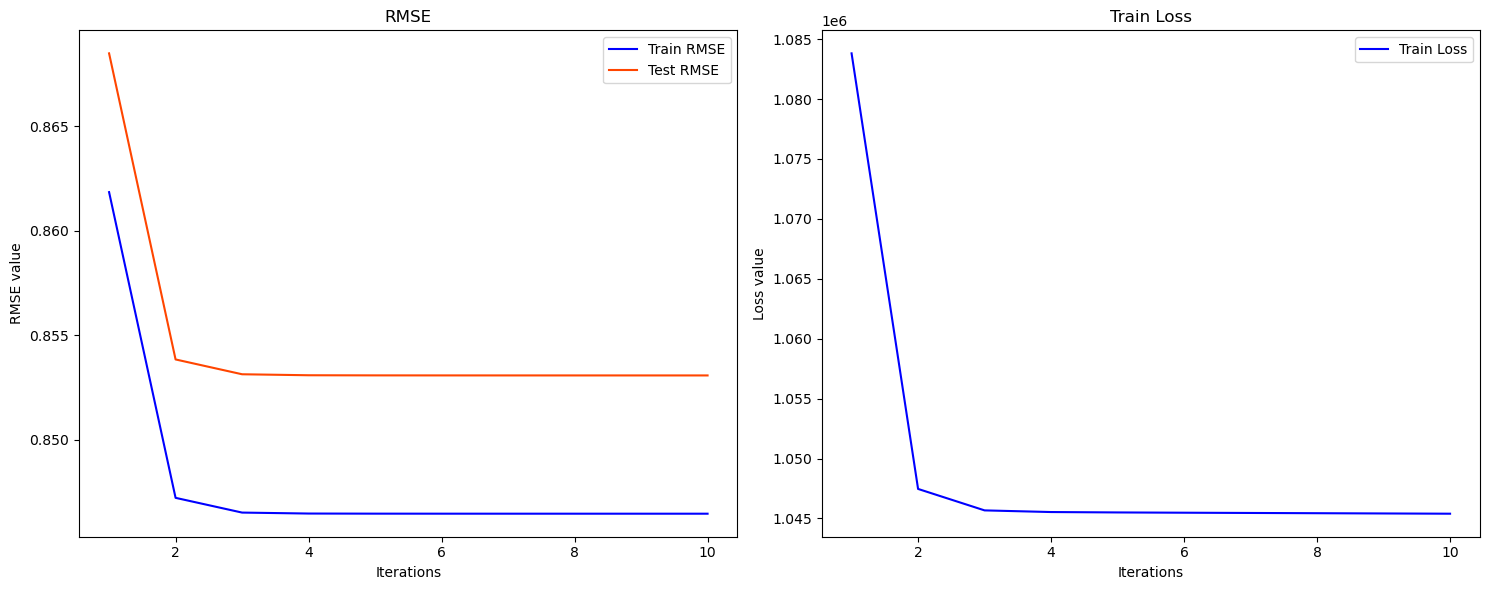

In [ ]:
# x-axis
iterations = np.arange(1, 11)

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot RMSE for training and testing
ax[0].plot(iterations, rmse_train_losses, label="Train RMSE", color="b")
ax[0].plot(iterations, rmse_test_losses, label="Test RMSE", color="orangered")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("RMSE value")
ax[0].set_title("RMSE")
ax[0].legend()

# Plot training loss
ax[1].plot(iterations, losses, label="Train Loss", color="b")
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Loss value")
ax[1].set_title("Train Loss")
ax[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
# Save model biases to a compressed .npz file
model_biases = {
    "user_biases": user_biases,
    "movie_biases": movie_biases
}

np.savez_compressed("model_biases_only.npz", **model_biases)
